In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
from pprint import pprint
from pathlib import Path

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## datasets (19.04 ~ 20.04)
# http://data.seoul.go.kr/dataList/OA-15182/F/1/datasetView.do#

In [2]:
# 2019.04 ~ 05 헤더정보 없음
# 2019.04 ~ 05 대여소 번호 보정

def stat_correction(n):
    if len(str(n)) == 1:
        return "0000" + str(n)
    elif len(str(n)) == 2:
        return "000" + str(n)
    elif len(str(n)) == 3:
        return "00" + str(n)
    elif len(str(n)) == 4:
        return "0" + str(n)
    else:
        return str(n)
    
col_name = [
    "자전거번호", 
    "대여일시", "대여 대여소번호", "대여 대여소명", "대여거치대", 
    "반납일시", "반납대여소번호", "반납 대여소명", "반납거치대", 
    "이용시간", "이용거리"]

# f_name = "서울특별시 공공자전거 대여정보_201904.csv"
# data = pd.read_csv(f"./datasets/{f_name}", encoding="949", header=0, names=col_name)
# data["대여 대여소번호"] = data["대여 대여소번호"].apply(stat_correction)
# data["반납대여소번호"] = data["반납대여소번호"].apply(stat_correction)
# data.to_csv(f"./datasets/{f_name}", encoding="949", index=False)

# f_name = "서울특별시 공공자전거 대여정보_201905.csv"
# data = pd.read_csv(f"./datasets/{f_name}", encoding="949", header=0, names=col_name)
# data["대여 대여소번호"] = data["대여 대여소번호"].apply(stat_correction)
# data["반납대여소번호"] = data["반납대여소번호"].apply(stat_correction)
# data.to_csv(f"./datasets/{f_name}", encoding="949", index=False)

In [3]:
data_dir = Path("./datasets")
fs = sorted(list(data_dir.glob("*.csv")))
pprint(fs)

[PosixPath('datasets/공공자전거 대여이력 정보_2020.01.csv'),
 PosixPath('datasets/공공자전거 대여이력 정보_2020.02.csv'),
 PosixPath('datasets/공공자전거 대여이력 정보_2020.03.csv'),
 PosixPath('datasets/공공자전거 대여이력 정보_2020.04.csv'),
 PosixPath('datasets/서울특별시 공공자전거 대여정보_201904.csv'),
 PosixPath('datasets/서울특별시 공공자전거 대여정보_201905.csv'),
 PosixPath('datasets/서울특별시 공공자전거 대여정보_201906_1.csv'),
 PosixPath('datasets/서울특별시 공공자전거 대여정보_201906_2.csv'),
 PosixPath('datasets/서울특별시 공공자전거 대여정보_201906_3.csv'),
 PosixPath('datasets/서울특별시 공공자전거 대여정보_201907_1.csv'),
 PosixPath('datasets/서울특별시 공공자전거 대여정보_201907_2.csv'),
 PosixPath('datasets/서울특별시 공공자전거 대여정보_201907_3.csv'),
 PosixPath('datasets/서울특별시 공공자전거 대여정보_201908_1.csv'),
 PosixPath('datasets/서울특별시 공공자전거 대여정보_201908_2.csv'),
 PosixPath('datasets/서울특별시 공공자전거 대여정보_201908_3.csv'),
 PosixPath('datasets/서울특별시 공공자전거 대여정보_201909_1.csv'),
 PosixPath('datasets/서울특별시 공공자전거 대여정보_201909_2.csv'),
 PosixPath('datasets/서울특별시 공공자전거 대여정보_201909_3.csv'),
 PosixPath('datasets/서울특별시 공공자전거 대여정보_201910_1.c

# Load

In [4]:
data_types = {c:str for c in col_name}
data = []

for f in tqdm(fs):
    d = pd.read_csv(f, encoding='949', dtype=data_types)
    # 특정 컬럼 선택
    d = d[["대여일시", "대여 대여소번호", "반납일시", "반납대여소번호"]]
    # 컬럼명 변경
    d.columns = ["rent_date", "rent_station", "return_date", "return_station"]
    # 시간 단위 변환
    d["rent_date"] = d["rent_date"].map(lambda x: x[:14]+"00:00")
    d["return_date"] = d["return_date"].map(lambda x: x[:14]+"00:00")
    
    data.append(d)
    
merged = pd.concat(data)
print(merged.shape)

100%|██████████| 24/24 [01:29<00:00,  3.71s/it]


(21713815, 4)


# Cleaning

In [5]:
merged.iloc[47100:47105, :]

# 이상한 값 발견

,rent_date,rent_station,return_date,return_station
47100,2020-01-03 06:00:00,01726,2020-01-03 06:00:00,00627
47101,2020-01-03 06:00:00,00364,2020-01-03 06:00:00,00361
47102,2020-01-03 06:00:00,01162,0270100:00,마곡나루역 5번출구 뒤편
47103,2020-01-03 06:00:00,02298,2020-01-03 06:00:00,02231
47104,2020-01-03 05:00:00,00164,2020-01-03 06:00:00,00170


In [6]:
# 이상한 값 제거
merged.index = range(len(merged))

remove_indexes = []
for i, s in enumerate(merged["return_station"]):
    try:
        int(s)
    except:
        remove_indexes.append(i)

merged = merged.drop(remove_indexes, axis=0)
merged.iloc[47100:47105, :]

,rent_date,rent_station,return_date,return_station
47100,2020-01-03 06:00:00,01726,2020-01-03 06:00:00,00627
47101,2020-01-03 06:00:00,00364,2020-01-03 06:00:00,00361
47103,2020-01-03 06:00:00,02298,2020-01-03 06:00:00,02231
47104,2020-01-03 05:00:00,00164,2020-01-03 06:00:00,00170
47105,2020-01-03 06:00:00,00231,2020-01-03 06:00:00,00238


# Preprocessing

In [7]:
rent_data = merged.iloc[:,:2]
# 날짜(시간)별 대여소별 대여 수 계산
rent_data["counts"] = 1
rent_grouped = rent_data.groupby(["rent_date", "rent_station"]).count().reset_index()

return_data = merged.iloc[:,2:]
# 날짜(시간)별 대여소별 반납 수 계산
return_data["counts"] = 1
return_grouped = return_data.groupby(["return_date", "return_station"]).count().reset_index()

rent_grouped.columns = ["date", "station", "rent_counts"]
return_grouped.columns = ["date", "station", "return_counts"]

# 날짜(시간) 및 대여소 번호 기준 병합
merged = pd.merge(rent_grouped, return_grouped, on=["station", "date"], how="outer")
merged = merged.sort_values(by=["station", "date"])

In [8]:
len(np.unique(merged["station"]))

# 총 대여소 수 1793개

1793

In [9]:
print(merged.shape)
merged.head(10)

# NaN 값은 해당 시간에 대여 or 반납 기록이 없는 것.

(9613755, 4)


,date,station,rent_counts,return_counts
7590916,2019-04-01 09:00:00,00003,NaN,1.0
10376,2019-04-01 17:00:00,00003,1.0,NaN
7597133,2019-04-02 09:00:00,00003,NaN,1.0
28436,2019-04-02 17:00:00,00003,1.0,NaN
7603164,2019-04-03 09:00:00,00003,NaN,1.0
46768,2019-04-03 17:00:00,00003,1.0,NaN
65564,2019-04-04 17:00:00,00003,1.0,NaN
84290,2019-04-05 17:00:00,00003,1.0,NaN
135057,2019-04-08 17:00:00,00003,1.0,NaN
7638455,2019-04-09 09:00:00,00003,NaN,1.0


In [10]:
# 각 대여소별로 전체 대여/반납 기록을 각각 합해보자

station_sum = merged[["station", "rent_counts", "return_counts"]].groupby(["station"]).sum().reset_index()
station_sum["total"] = station_sum[["rent_counts", "return_counts"]].sum(axis=1)
station_sum.head(10)

# 7번 대여소는 모든 기간(19.05 ~ 20.04)동안 총 100회 미만의 대여/반납 수를 기록하지만,
# 102번, 103번, 106번 대여소는 총 기록이 4만회가 넘는다.

,station,rent_counts,return_counts,total
0,00003,241.0,331.0,572.0
1,00005,72.0,130.0,202.0
2,00007,28.0,57.0,85.0
3,00010,673.0,644.0,1317.0
4,00101,9557.0,9818.0,19375.0
5,00102,39094.0,37046.0,76140.0
6,00103,26223.0,25842.0,52065.0
7,00104,23588.0,21678.0,45266.0
8,00105,12376.0,11587.0,23963.0
9,00106,47827.0,47944.0,95771.0


Text(0.5, 1.0, 'Total')

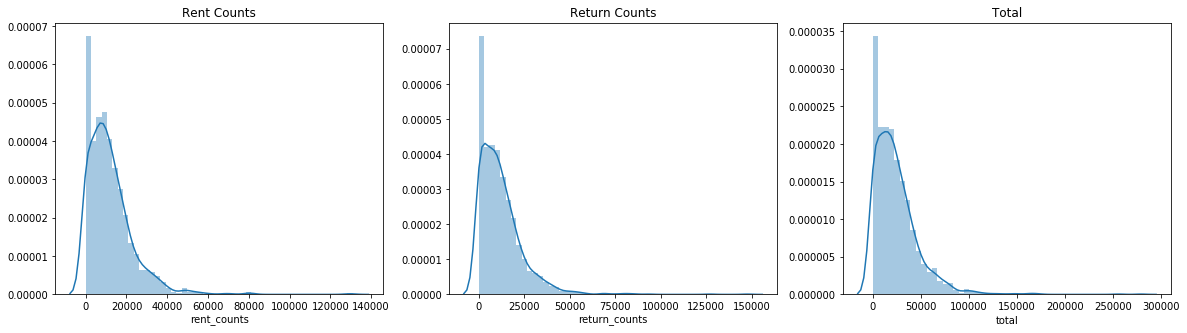

In [11]:
# 각 대여소별 총 대여/반납 수를 히스토그램으로 나타내본다.

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,5))
plt.subplot(1,3,1); sns.distplot(station_sum["rent_counts"]); plt.title("Rent Counts")
plt.subplot(1,3,2); sns.distplot(station_sum["return_counts"]); plt.title("Return Counts")
plt.subplot(1,3,3); sns.distplot(station_sum["total"]); plt.title("Total")

# 대부분 0에 가까운 값을 가진다.

In [12]:
# 대여 및 반납이 활발한 대여소만 분석에 활용.
# 여기서는 수집한 데이터의 총 기간(19.04 ~ 20.04, 396일)동안 대여 및 반납의 합이 하루 평균 150회 이상인 대여소만 선택.
# (396 * 150 = 59400 이상 선택)

station_sum = station_sum[station_sum["total"] >= 59400]

print(station_sum.shape)
station_sum.head()

# 상위 128개 대여소가 분석 대상으로 선택됨. (총 대여소는 약 1800개)

(128, 4)


,station,rent_counts,return_counts,total
5,00102,39094.0,37046.0,76140.0
9,00106,47827.0,47944.0,95771.0
10,00107,29133.0,35060.0,64193.0
16,00113,79053.0,93580.0,172633.0
17,00114,35745.0,37332.0,73077.0


In [13]:
# 128개 대여소 목록

station_no = list(station_sum["station"])
print(station_no)

['00102', '00106', '00107', '00113', '00114', '00117', '00144', '00146', '00152', '00183', '00202', '00207', '00210', '00211', '00222', '00228', '00230', '00232', '00247', '00248', '00259', '00272', '00274', '00284', '00358', '00361', '00409', '00418', '00419', '00421', '00500', '00502', '00504', '00505', '00509', '00512', '00513', '00525', '00565', '00567', '00568', '00583', '00585', '00589', '00590', '00592', '00602', '00634', '00646', '00703', '00704', '00816', '00825', '00829', '00907', '00914', '01008', '01009', '01011', '01019', '01020', '01044', '01050', '01112', '01118', '01124', '01149', '01153', '01158', '01160', '01166', '01173', '01197', '01209', '01210', '01211', '01212', '01222', '01243', '01251', '01268', '01295', '01308', '01337', '01403', '01503', '01601', '01608', '01611', '01616', '01625', '01636', '01637', '01653', '01663', '01673', '01721', '01906', '01911', '01925', '01961', '01985', '02002', '02025', '02050', '02102', '02173', '02177', '02183', '02217', '02219', 

In [14]:
# 128개 대여소 정보만 추출

data = []

for s in tqdm(station_no):
    d = merged[merged["station"] == s]
    data.append(d)
    
data = pd.concat(data)
print(data.shape)

100%|██████████| 128/128 [01:10<00:00,  1.82it/s]

(1060145, 4)


In [15]:
data = data.sort_values(by=["station", "date"])
data.head(10)

# NaN 값은 대여 또는 반납이 없었으므로 0으로 채워야하고,
# 없는 시간대 또한 0 값을 채워야 함 (아래에서는 4월 1일 3~6시 없음)

,date,station,rent_counts,return_counts
0,2019-04-01 00:00:00,00102,5.0,1.0
439,2019-04-01 01:00:00,00102,3.0,3.0
7589560,2019-04-01 02:00:00,00102,NaN,1.0
7590439,2019-04-01 07:00:00,00102,NaN,2.0
2849,2019-04-01 08:00:00,00102,5.0,5.0
3962,2019-04-01 09:00:00,00102,6.0,4.0
4800,2019-04-01 10:00:00,00102,4.0,NaN
5485,2019-04-01 11:00:00,00102,1.0,3.0
6193,2019-04-01 12:00:00,00102,3.0,1.0
7038,2019-04-01 13:00:00,00102,1.0,3.0


In [16]:
# NaN -> 0
data = data.fillna(0)
data.head(10)

,date,station,rent_counts,return_counts
0,2019-04-01 00:00:00,00102,5.0,1.0
439,2019-04-01 01:00:00,00102,3.0,3.0
7589560,2019-04-01 02:00:00,00102,0.0,1.0
7590439,2019-04-01 07:00:00,00102,0.0,2.0
2849,2019-04-01 08:00:00,00102,5.0,5.0
3962,2019-04-01 09:00:00,00102,6.0,4.0
4800,2019-04-01 10:00:00,00102,4.0,0.0
5485,2019-04-01 11:00:00,00102,1.0,3.0
6193,2019-04-01 12:00:00,00102,3.0,1.0
7038,2019-04-01 13:00:00,00102,1.0,3.0


In [17]:
# 전체 기간의 날짜 및 시간
year_month = [
    "2019-04", "2019-05", "2019-06", "2019-07", "2019-08", "2019-09", "2019-10", "2019-11", "2019-12",
    "2020-01", "2020-02", "2020-03", "2020-04"
]
day_length = [30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 29, 31, 30]

total_time = []
for ym, day in zip(year_month, day_length):
    for d in range(1, day+1):
        if len(str(d)) == 1:
            d = "0" + str(d)
        else:
            d = str(d)
            
        for t in range(0, 24):
            if len(str(t)) == 1:
                t = "0" + str(t)
            else:
                t = str(t)
            
            date = f"{ym}-{d} {t}:00:00"
            total_time.append(date)
            
print(total_time[:10])
print(total_time[-10:])

['2019-04-01 00:00:00', '2019-04-01 01:00:00', '2019-04-01 02:00:00', '2019-04-01 03:00:00', '2019-04-01 04:00:00', '2019-04-01 05:00:00', '2019-04-01 06:00:00', '2019-04-01 07:00:00', '2019-04-01 08:00:00', '2019-04-01 09:00:00']
['2020-04-30 14:00:00', '2020-04-30 15:00:00', '2020-04-30 16:00:00', '2020-04-30 17:00:00', '2020-04-30 18:00:00', '2020-04-30 19:00:00', '2020-04-30 20:00:00', '2020-04-30 21:00:00', '2020-04-30 22:00:00', '2020-04-30 23:00:00']


In [18]:
# 각 대여소 마다 빠진 시간이 있는지 체크, 없으면 0 채워 넣기

prep_data = []

for s in tqdm(station_no):
    d = data[data["station"] == s]
    s_time = list(d["date"])
    _time = list(set(total_time) - set(s_time))
    
    df_0 = pd.DataFrame({"date":_time, "station":s, "rent_counts":0, "return_counts":0})
    df = pd.concat([d, df_0])
    
    prep_data.append(df)
    
prep_data = pd.concat(prep_data)
prep_data = prep_data.sort_values(by=["station", "date"])

100%|██████████| 128/128 [00:08<00:00, 14.72it/s]


In [19]:
print(len(prep_data))
print(len(prep_data)/128)

# 128개 대여소별로 각각 9504개 데이터를 갖는다. (총 396일 * 24시간 = 9504)

1216512
9504.0


In [20]:
prep_data.index = range(len(prep_data))

In [21]:
# prep_data.to_csv("./datasets/prep/prep.csv", index=False)
prep_data = pd.read_csv("./datasets/prep/prep.csv", dtype={"date":str, "station":str, "rent_counts":int, "return_counts":int})

In [22]:
prep_data.head(10)

,date,station,rent_counts,return_counts
0,2019-04-01 00:00:00,00102,5,1
1,2019-04-01 01:00:00,00102,3,3
2,2019-04-01 02:00:00,00102,0,1
3,2019-04-01 03:00:00,00102,0,0
4,2019-04-01 04:00:00,00102,0,0
5,2019-04-01 05:00:00,00102,0,0
6,2019-04-01 06:00:00,00102,0,0
7,2019-04-01 07:00:00,00102,0,2
8,2019-04-01 08:00:00,00102,5,5
9,2019-04-01 09:00:00,00102,6,4


# + time info

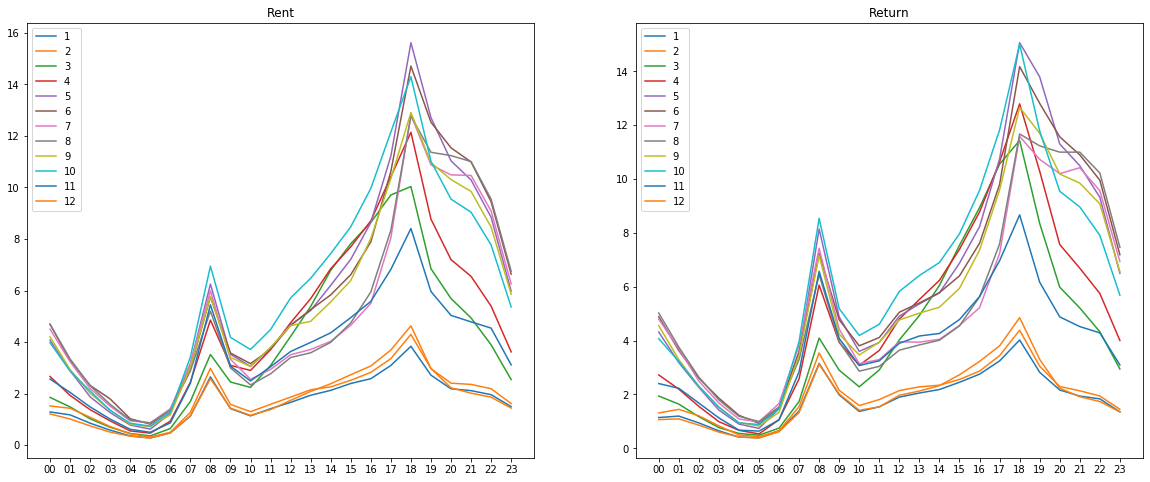

In [23]:
# 모든 대여소 대상 하루 시간대 별 대여/반납 수 평균 (달 별)
month_data = prep_data.copy()

month_data["month"] = month_data["date"].apply(lambda x: int(x[5:7]))
month_data["date"] = month_data["date"].apply(lambda x: x[11:13])

plt.figure(figsize=(20,8))

for month in range(1, 13):
    _month_data = month_data.loc[(month_data["month"] == month)]
    _month_data = _month_data[["date", "rent_counts", "return_counts"]].groupby(["date"]).mean().reset_index()
    plt.subplot(1,2,1); plt.plot(_month_data["date"], _month_data["rent_counts"], label=str(month)); plt.legend(); plt.title("Rent")
    plt.subplot(1,2,2); plt.plot(_month_data["date"], _month_data["return_counts"], label=str(month)); plt.legend(); plt.title("Return")
        
# 시간에 따라 패턴은 비슷하지만 달 별로 대여/반납 수의 차이가 있다. (겨울에 적고, 4월~9월에 많다)

In [24]:
# 달 정보 추가
month_one_hot = pd.get_dummies(month_data["month"], prefix="month")
data = pd.concat([prep_data, month_one_hot], axis=1)

data.head(3)

,date,station,rent_counts,return_counts,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2019-04-01 00:00:00,00102,5,1,0,0,0,1,0,0,0,0,0,0,0,0
1,2019-04-01 01:00:00,00102,3,3,0,0,0,1,0,0,0,0,0,0,0,0
2,2019-04-01 02:00:00,00102,0,1,0,0,0,1,0,0,0,0,0,0,0,0


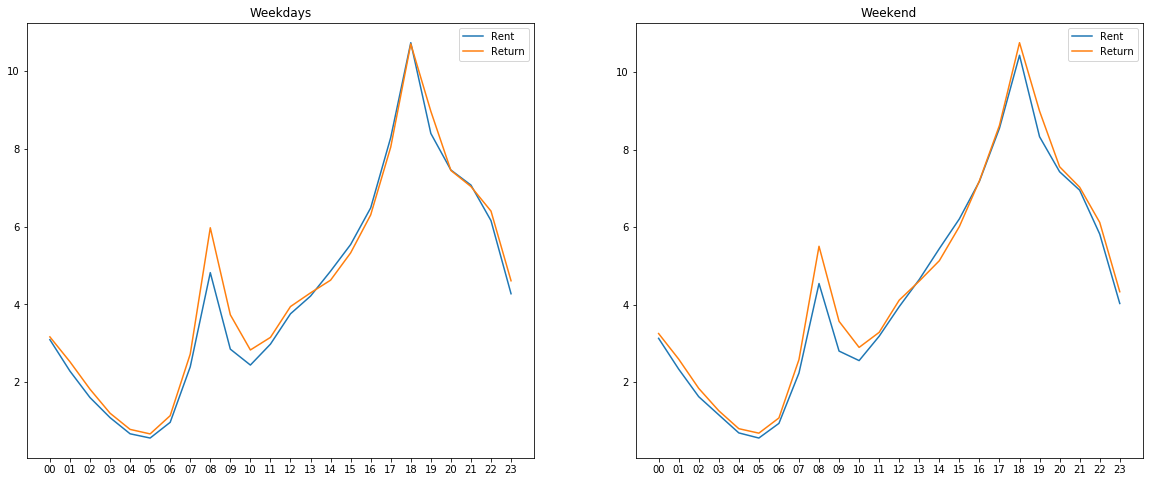

In [25]:
# 모든 대여소 대상 하루 시간대 별 대여/반납 수 평균 (평일 / 주말)
week_data = prep_data.copy()

weeks = ["mon", "tue", "wed", "thu", "fri", "sat", "sun"] * 1000000

total_weeks = []
ref, ind = "1", 0
for time in total_time:
    if ref == time[9]:
        total_weeks.append(weeks[ind])
    else:
        ref = time[9]
        ind += 1
        total_weeks.append(weeks[ind])
        
weeks_data = pd.DataFrame({"date":total_time, "week":total_weeks})

# 요일 컬럼 추가
week_data = pd.merge(week_data, weeks_data, on=["date"], how="inner")

week_data["date"] = week_data["date"].apply(lambda x: x[11:13])

weekdays = week_data.loc[
    (week_data["week"]=="mon") | (week_data["week"]=="the") | (week_data["week"]=="wed") |
    (week_data["week"]=="thu") | (week_data["week"]=="fri")
]
weekend = week_data.loc[
    (week_data["week"]=="sat") | (week_data["week"]=="sun") 
]

weekdays_group = weekdays[["date", "rent_counts", "return_counts"]].groupby(["date"]).mean().reset_index()
weekend_group = weekend[["date", "rent_counts", "return_counts"]].groupby(["date"]).mean().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,2,1); plt.plot(weekdays_group["date"], weekdays_group["rent_counts"], label="Rent")
plt.subplot(1,2,1); plt.plot(weekdays_group["date"], weekdays_group["return_counts"], label="Return"); plt.title("Weekdays"); plt.legend()
plt.subplot(1,2,2); plt.plot(weekend_group["date"], weekend_group["rent_counts"], label="Rent")
plt.subplot(1,2,2); plt.plot(weekend_group["date"], weekend_group["return_counts"], label="Return"); plt.title("Weekend"); plt.legend()

# 평일 출근시간대(7~10시) 자전거 이용이 살짝 높고 퇴근시간대(17~19시) 이용 매우 높다
# 주말은 평일 패턴과 거의 비슷하다.

In [26]:
# 요일 정보 더하기 (one-hot)
week_one_hot = pd.get_dummies(week_data["week"], prefix="week")
data = pd.concat([data, week_one_hot], axis=1)

data.head(3)

,date,station,rent_counts,return_counts,month_1,month_2,month_3,month_4,month_5,month_6,...,month_10,month_11,month_12,week_fri,week_mon,week_sat,week_sun,week_thu,week_tue,week_wed
0,2019-04-01 00:00:00,00102,5,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2019-04-01 01:00:00,00102,3,3,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2019-04-01 02:00:00,00102,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [27]:
# 1시간 정보 더하기 (one-hot)
time_one_hot = prep_data.copy()["date"].apply(lambda x: x[11:13]) # 시간 부분 추출
time_one_hot = pd.get_dummies(time_one_hot, prefix="hour")
data = pd.concat([data, time_one_hot], axis=1)

data.head(3)

,date,station,rent_counts,return_counts,month_1,month_2,month_3,month_4,month_5,month_6,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,2019-04-01 00:00:00,00102,5,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2019-04-01 01:00:00,00102,3,3,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2019-04-01 02:00:00,00102,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# 6시간 단위 정보 더하기 (one-hot)
# (00~06, 06~12, 12~18, 18~00)
def get_qtime(s):
    s = s[11:13]
    if 0<=int(s)<6: return "0"
    elif 6<=int(s)<12: return "1"
    elif 12<=int(s)<18: return "2"
    else: return "3"

qtime_one_hot = prep_data.copy()["date"].apply(get_qtime)
qtime_one_hot = pd.get_dummies(qtime_one_hot, prefix="qhour")
data = pd.concat([data, qtime_one_hot], axis=1)

data.head(3)

,date,station,rent_counts,return_counts,month_1,month_2,month_3,month_4,month_5,month_6,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,qhour_0,qhour_1,qhour_2,qhour_3
0,2019-04-01 00:00:00,00102,5,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2019-04-01 01:00:00,00102,3,3,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2019-04-01 02:00:00,00102,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


# + weather

In [29]:
weather = pd.read_csv("./datasets/prep/weather_info.csv", encoding="949")
weather["일시"] = total_time
weather.head()

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위)
0,108,서울,2019-04-01 00:00:00,2.6,NaN,2.3,36.0,NaN,NaN,NaN,0.0
1,108,서울,2019-04-01 01:00:00,1.8,NaN,0.7,44.0,NaN,NaN,NaN,3.0
2,108,서울,2019-04-01 02:00:00,1.2,NaN,0.6,50.0,NaN,NaN,NaN,2.0
3,108,서울,2019-04-01 03:00:00,0.7,NaN,0.6,53.0,NaN,NaN,NaN,0.0
4,108,서울,2019-04-01 04:00:00,0.4,NaN,0.8,55.0,NaN,NaN,NaN,0.0


In [30]:
weather = weather.iloc[:, 2:]
weather.columns = ["date", "temperature", "precipitation", "wind_speed", "humidity", "sunshine", "insolation", "snow", "cloud"]

weather.head()

,date,temperature,precipitation,wind_speed,humidity,sunshine,insolation,snow,cloud
0,2019-04-01 00:00:00,2.6,NaN,2.3,36.0,NaN,NaN,NaN,0.0
1,2019-04-01 01:00:00,1.8,NaN,0.7,44.0,NaN,NaN,NaN,3.0
2,2019-04-01 02:00:00,1.2,NaN,0.6,50.0,NaN,NaN,NaN,2.0
3,2019-04-01 03:00:00,0.7,NaN,0.6,53.0,NaN,NaN,NaN,0.0
4,2019-04-01 04:00:00,0.4,NaN,0.8,55.0,NaN,NaN,NaN,0.0


In [31]:
# Nan -> 0
weather = weather.fillna(0)
weather.head()

,date,temperature,precipitation,wind_speed,humidity,sunshine,insolation,snow,cloud
0,2019-04-01 00:00:00,2.6,0.0,2.3,36.0,0.0,0.0,0.0,0.0
1,2019-04-01 01:00:00,1.8,0.0,0.7,44.0,0.0,0.0,0.0,3.0
2,2019-04-01 02:00:00,1.2,0.0,0.6,50.0,0.0,0.0,0.0,2.0
3,2019-04-01 03:00:00,0.7,0.0,0.6,53.0,0.0,0.0,0.0,0.0
4,2019-04-01 04:00:00,0.4,0.0,0.8,55.0,0.0,0.0,0.0,0.0


In [32]:
print(len(prep_data), len(weather))

1216512 9504


In [33]:
add_weather = pd.merge(data, weather, on=["date"], how="inner")
add_weather = add_weather.sort_values(by=["station", "date"])

add_weather.head()

## 관련 feature 추가 시 date에 알맞게 추가하면 됨

,date,station,rent_counts,return_counts,month_1,month_2,month_3,month_4,month_5,month_6,...,qhour_2,qhour_3,temperature,precipitation,wind_speed,humidity,sunshine,insolation,snow,cloud
0,2019-04-01 00:00:00,00102,5,1,0,0,0,1,0,0,...,0,0,2.6,0.0,2.3,36.0,0.0,0.0,0.0,0.0
128,2019-04-01 01:00:00,00102,3,3,0,0,0,1,0,0,...,0,0,1.8,0.0,0.7,44.0,0.0,0.0,0.0,3.0
256,2019-04-01 02:00:00,00102,0,1,0,0,0,1,0,0,...,0,0,1.2,0.0,0.6,50.0,0.0,0.0,0.0,2.0
384,2019-04-01 03:00:00,00102,0,0,0,0,0,1,0,0,...,0,0,0.7,0.0,0.6,53.0,0.0,0.0,0.0,0.0
512,2019-04-01 04:00:00,00102,0,0,0,0,0,1,0,0,...,0,0,0.4,0.0,0.8,55.0,0.0,0.0,0.0,0.0


In [34]:
add_weather.to_csv("./datasets/prep/dataset.csv", index=False)